In [1]:
import numpy as np

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from plot_data import *
from data_loading import *

import json

from approaches.gaussian_predictor_levelsets import *
from approaches.gaussian_trainer import *

from standardized_residuals import StandardizedResiduals

seed_everything(42)

In [2]:
seed_everything(42)

class RadiusTransformation2:
    def __init__(self, d, beta=None):
        if beta is None:
            beta = np.random.randn(d)
        self.beta = beta

    def get(self, x):
        return ((( np.linalg.norm(x)) / 2.0 + (np.dot(self.beta, x))**2 / 10) / 2 ) / .5 + 0.15
        return ( np.linalg.norm(x)) / 2.0 + np.exp(np.dot(self.beta, x))

d = 2
k = 2

pert = "gaussian"

n_train = 1_000
n_test = 1_000
n_calibration = 1_000
n_stop = 1_000
n_anchors = 10



config_name = "gau_t"

config_path = "../parameters/" + config_name + ".json"

with open(config_path, 'r') as file : 
    parameters = json.load(file)



alpha = 0.1

class NonLinearFunction2:
    def __init__(self, d, k, beta=None):
        if beta is None:
            beta = np.random.randn(d, k)
        self.beta = beta
        self.proj  = np.zeros((d, k))
        self.proj[0, 0] = 1.0
        self.proj[1, 1] = 1.0

    def get(self, x):
        nonlinear_term = np.sin(np.dot(x, self.beta)) + 0.5 * np.tanh(np.dot(x**2, self.beta)) + np.dot(x, self.proj)
        return nonlinear_term * 2

f_star = NonLinearFunction2(d, k)
radius = RadiusTransformation2(d)
local_perturbation = LocalPerturbation(d, k, n_anchors=n_anchors, radius_transformation=radius)
data_generator = DataGenerator(d, k, pert, f_star=f_star, local_perturbation=local_perturbation, covariance_matrix=np.array([[1.0, 0.5],[0.5, 1.0]]), bias = False, seed = 42)

x_train, y_train = data_generator.generate(n_train)
x_stop, y_stop = data_generator.generate(n_stop)
x_calibration, y_calibration = data_generator.generate(n_calibration)
x_test, y_test = data_generator.generate(n_test)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float32)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



In [3]:
seed_everything(42)

input_dim = d
output_dim = k
hidden_dim = 128
num_layers = 3
batch_size = 32
num_epochs = 10
lr = 1e-3
dtype = torch.float32

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size, shuffle=True)

gaussian_trainer = GaussianTrainer(input_dim, 
                            output_dim,
                            hidden_dim = hidden_dim,
                            num_layers = num_layers
                            )

gaussian_trainer.fit(trainloader, 
                    stoploader,
                    num_epochs=num_epochs,
                    lr=lr,
                    verbose = 2
                    )



/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/approaches/gaussian_trainer.py:112: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2259.)
  z = torch.triangular_solve(diff, L, upper=False)[0]


Epoch 1: Avg NLL Loss = 2.7115 -- Stop loss: 1.6292 -- Best Stop Loss: inf
Epoch 2: Avg NLL Loss = 1.2606 -- Stop loss: 0.7769 -- Best Stop Loss: 1.6292422227561474
Epoch 3: Avg NLL Loss = 0.6981 -- Stop loss: 0.7866 -- Best Stop Loss: 0.7769224066287279
Epoch 4: Avg NLL Loss = 0.6917 -- Stop loss: 0.5136 -- Best Stop Loss: 0.7769224066287279
Epoch 5: Avg NLL Loss = 0.5816 -- Stop loss: 0.4854 -- Best Stop Loss: 0.513576548313722
Epoch 6: Avg NLL Loss = 0.5575 -- Stop loss: 0.5426 -- Best Stop Loss: 0.4854100700467825
Epoch 7: Avg NLL Loss = 0.4904 -- Stop loss: 0.4517 -- Best Stop Loss: 0.4854100700467825
Epoch 8: Avg NLL Loss = 0.4642 -- Stop loss: 0.5709 -- Best Stop Loss: 0.4517173497006297
Epoch 9: Avg NLL Loss = 0.4807 -- Stop loss: 0.5667 -- Best Stop Loss: 0.4517173497006297
Best stop loss achieved: 0.4517


In [4]:
center_model = gaussian_trainer.center_model
matrix_model = gaussian_trainer.matrix_model

gaussian_level_sets = GaussianPredictorLevelsets(center_model, matrix_model, dtype=dtype)
standardized_residuals = StandardizedResiduals(input_dim, output_dim)
standardized_residuals.trainer.backbone = gaussian_trainer.backbone
standardized_residuals.trainer.head = gaussian_trainer.head

In [5]:
gaussian_level_sets.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)
standardized_residuals.conformalize(x=x_calibration_tensor, y=y_calibration_tensor, alpha= alpha)

2.0083632469177246

In [6]:
print(gaussian_level_sets.get_averaged_volume(x=x_test_tensor))
print(standardized_residuals.get_average_volume(x=x_test_tensor))

tensor(3.0513)
3.051339864730835


In [7]:
idx_knowned = np.array([0])

gaussian_level_sets.conformalize_with_knowned_idx(x_calibration=x_calibration_tensor, 
                                            y_calibration=y_calibration_tensor, 
                                            alpha = alpha, 
                                            idx_knowned=idx_knowned)


standardized_residuals.conformalize_revealed(idx_revealed = idx_knowned,
                                            x = x_calibration_tensor, 
                                            y = y_calibration_tensor, 
                                            alpha = alpha
                                            )


coverage = standardized_residuals.get_coverage_revealed(x_test_tensor, y_test_tensor)
volumes  = standardized_residuals.get_average_volume_revealed(x_test_tensor, y_test_tensor[:, idx_knowned])

print("Coverage:", coverage)
print("Average Volume:", volumes)

print("Volume :", gaussian_level_sets.get_averaged_volume_condition_on_idx(x_test_tensor, y_test_tensor[:, idx_knowned]))

Coverage: 0.9079999923706055
Average Volume: 2.783097267150879
Volume : tensor(2.7831)


In [8]:
projection_matrix_tensor =  torch.randn((2, output_dim), dtype=dtype)

standardized_residuals.conformalize_projection(
                                            projection_matrix = projection_matrix_tensor,
                                            x = x_calibration_tensor, 
                                            y = y_calibration_tensor, 
                                            alpha = alpha
                                            )

gaussian_level_sets.conformalize_linear_projection(projection_matrix=projection_matrix_tensor, x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha=alpha)


coverage = standardized_residuals.get_coverage_projection(x_test_tensor, y_test_tensor)
volumes  = standardized_residuals.get_average_volume_projection(x_test_tensor)

print("Coverage:", coverage)
print("Average Volume:", volumes)

print(gaussian_level_sets.get_averaged_volume_projection(x_test_tensor))

Coverage: 0.890999972820282
Average Volume: 2.3245644569396973
tensor(2.3246)


/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_25892/2951388689.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/plot_data.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_25892/2951388689.py:87: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same

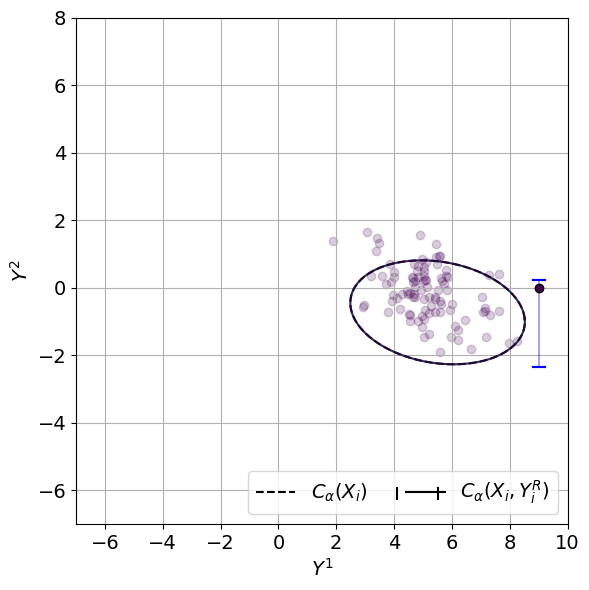

In [9]:
tab_seed = [14]
q_val = 2.0
dtype = torch.float32

coverage_emp = []

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 

fig, ax = plt.subplots(figsize=(6, 6))


color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        if seed == 14:
                y_specific[0] = np.array([9.0, 0.0])

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        centers = gaussian_level_sets.get_centers(x_specific_tensor)
        centers_np = centers.detach().numpy()
        Lambdas_specific = gaussian_level_sets.get_Lambdas(x_specific_tensor)
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        radius = gaussian_level_sets.nu_conformal.item()

        center_st, gaussian_st = standardized_residuals.get_distribution(x_specific_tensor)
        center_st_np, gaussian_st_np = center_st.detach().numpy(), gaussian_st.detach().numpy()
        gaussian_st_np = get_Lambdas_from_Sigmas(gaussian_st_np[0])
        radius_st = standardized_residuals.q_alpha

        
        
        ax = add_ellipse(ax,  center_st_np[0], gaussian_st_np, q_val, radius_st, color = darker_viridis(i+1), linestyle='-', label=None)
        ax = add_ellipse(ax,  centers_np[0], Lambdas_specific_np[0], q_val, radius, color = darker_viridis(i), linestyle='--', label=None)

        coverage_emp.append(gaussian_level_sets.get_coverage(x_specific_tensor, y_specific_tensor))
        
        y_values = []
        for j in range(1):
                t = y_specific_tensor[j, 0]                
                for y in np.linspace(-10, 10, 10_000):  # Plage de valeurs pour y
                        t_y = torch.tensor([t, y], dtype = dtype).unsqueeze(0)                         
                        
                        y_r = t_y[:, idx_knowned]
                        y_s = t_y[:, idx_unknown]

                        inside = gaussian_level_sets.get_coverage_condition_on_idx(x_specific_tensor[[0]] ,t_y)

                        if inside:
                                y_values.append(y)


                ax.plot([t, t], [min(y_values), max(y_values)], color=darker_viridis(i),  label=None, alpha = 0.2)
                ax.plot([t-0.2, t+0.2], [min(y_values), min(y_values)], label=None, color=darker_viridis(i))
                ax.plot([t-0.2, t+0.2], [max(y_values), max(y_values)], label=None, color=darker_viridis(i))

        y_values = []
        for j in range(1):
                t = y_specific_tensor[j, 0]                
                for y in np.linspace(-10, 10, 10_000):  # Plage de valeurs pour y
                        t_y = torch.tensor([t, y], dtype = dtype).unsqueeze(0)                         
                        
                        y_r = t_y[:, idx_knowned]
                        y_s = t_y[:, idx_unknown]

                        inside = gaussian_level_sets.get_coverage_condition_on_idx(x_specific_tensor[[0]] ,t_y)
                        inside = standardized_residuals.get_coverage_revealed(x_specific_tensor[[0]] ,t_y)

                        if inside:
                                y_values.append(y)


                ax.plot([t, t], [min(y_values), max(y_values)], color="blue",  label=None, alpha = 0.2)
                ax.plot([t-0.2, t+0.2], [min(y_values), min(y_values)], label=None, color="blue")
                ax.plot([t-0.2, t+0.2], [max(y_values), max(y_values)], label=None, color="blue")
       
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.2)
        ax.scatter(y_specific[0, 0], y_specific[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

ax = add_ellipse(ax,  centers_np[0] + np.array([100, 100]), Lambdas_specific_np[0], q_val, radius, color = "black", linestyle='--', label=fr'$C_\alpha(X_{{i}})$')
ax.plot([t, t], [min(y_values)+ 100, max(y_values)+100], color="black",  label=fr'$C_\alpha(X_{{i}}, Y_{{i}}^{{R}})$')

ax.set_xlabel(r'$Y^1$', fontsize=14)
ax.set_ylabel(r'$Y^2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
leg = ax.legend(fontsize=14, loc='lower right', ncols=2)
ax.set_xlim(-7, 10)
ax.set_ylim(-7, 8)
leg.set_zorder(2)

ax.plot([4.1, 4.1], [-6.25, -5.95], color="black", zorder=3)
ax.plot([5.5, 5.5], [-6.25, -5.95], color="black", zorder=3)
        
plt.grid(True)

plt.tight_layout()

plt.show()

plt.close()



In [10]:
new_centers, new_Lambdas = get_new_centers_Lambdas_with_knowned_idx(y_r, centers, Lambdas_specific, idx_knowned)
print(new_centers[0])
print(new_Lambdas[0])

tensor([-1.0603], grad_fn=<SelectBackward0>)
tensor([[1.3268]], grad_fn=<SelectBackward0>)


In [11]:
print(gaussian_level_sets.nu_conformal_conditional)
print(standardized_residuals.q_alpha_revealed**2)

tensor(1.7224)
2.96661025655807


In [12]:
new_centers_st, new_Sigma_st = standardized_residuals.get_revealed_distribution(x_specific_tensor, idx_knowned, y_r)
new_Lambdas_st = get_Lambdas_from_Sigmas(new_Sigma_st)
print(new_centers_st[0], new_Lambdas_st[0])

tensor([-1.0603], grad_fn=<SelectBackward0>) tensor([[1.3268]], grad_fn=<SelectBackward0>)


In [13]:
y_r = t_y[:, idx_knowned]
print(standardized_residuals.get_average_volume_revealed(x_specific_tensor, y_r))
print(gaussian_level_sets.get_averaged_volume_condition_on_idx(x_specific_tensor, y_r))

2.5963258743286133
tensor(2.5963)
